In [10]:
import string
import nltk
# nltk.download()
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import re
import sys
import numpy as np
import pandas as pd
import pickle
import os
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from os import listdir
from os.path import isfile, join
import copy

In [2]:
def nltk_ops(text, stem='True'):
    words = word_tokenize(text)
    stop_words = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words]
    if stem:
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in filtered_words]
    else:
        stemmed = filtered_words
    return stemmed

def clean_and_pkl(rfc_files):
    """
    make a csv/txt will all pickled rfcs
    """
    cnt = 0
    cleaned_rfcs = []
    rfc_pkl = {}
    for f in rfc_files:
        f = 'rfcs/'+f
        try:
            with open(f,'r') as fh:
                print('processing:', f)
                basename = Path(f).stem
                text = fh.read()
                text = text.lower()
                text_p = "".join([char for char in text if char not in string.punctuation])
                text_p = ' '.join(text_p.split())
                re.sub('\s+',' ',text_p)
                text_p = ''.join([i for i in text_p if not i.isdigit()])
                stemmed_text_p = nltk_ops(text_p, True)
                final_cleaned = ' '.join(stemmed_text_p)
                cleaned_rfcs.append(final_cleaned)
                # dict for pickle file text
                rfc_pkl[basename] = final_cleaned
                cnt+=1
        except:
            pass
            # print('skipping file:', f)
    print('total RFCs cleaned and pickled :', cnt)
    # pickle the dict
    with open('rfc_pkl.pkl', 'wb') as fh:
        pickle.dump(rfc_pkl, fh, protocol=pickle.HIGHEST_PROTOCOL)
    
    return cleaned_rfcs

In [9]:
def main():
    if os.path.exists('rfc_pkl.pkl'):
        print('loading cleaned RFCs from pkl')
        # load pickle file
        rfc_dict = pickle.load(open( 'rfc_pkl.pkl', "rb" ))
        cleaned_rfcs = list(rfc_dict.values())
    else:
        print('cleaning and pickling RFCs')
        # rfc_dir = 'rfcs'
        # rfc_files = ['rfcs/rfc{}.txt'.format(x) for x in range(2000,2200)]
        rfc_files = [f for f in listdir('../rfcs') if isfile(join('../rfcs', f))]
        cleaned_rfcs = clean_and_pkl(rfc_files)

    vectorizer = TfidfVectorizer(min_df=1, stop_words="english")
    transformed_rfcs = vectorizer.fit_transform(cleaned_rfcs)
    # print(transformed_rfcs)
    # print(transformed_rfcs[0].T.todense())

    # print the term freq-inv doc freq
    # df = pd.DataFrame(transformed_rfcs[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
    # df = df.sort_values('TF-IDF', ascending=False)
    # print(df.head(50))

    # pairwise similarity
    pairwise_sim = transformed_rfcs*transformed_rfcs.T
    # print('pairwise doc similarity matrix (sparse) :', pairwise_sim)
    sim_array = pairwise_sim.toarray()
    # fill diagonals with nan to mask 1's
    # np.fill_diagonal(sim_array, np.nan)
    return sim_array

sim_array = main()

loading cleaned RFCs from pkl


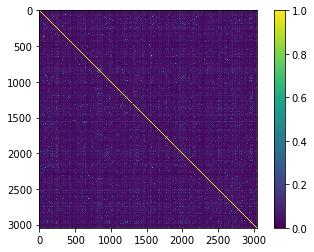

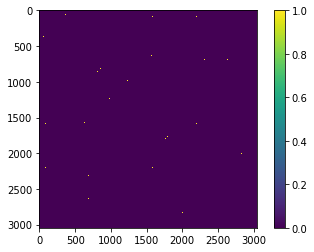

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


sim_array_copy = copy.deepcopy(sim_array)


plt.imshow(sim_array_copy)
plt.colorbar()
plt.show()

np.fill_diagonal(sim_array_copy, 0)
threshold = 0.6
sim_array_copy[sim_array_copy<threshold]=0
sim_array_copy[sim_array_copy>threshold]=1

plt.imshow(sim_array_copy)
plt.colorbar()
plt.show()
# print('pairwise doc similarity matrix numpy:', sim_array)
# print(sim_array.shape)

In [5]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
graph = csr_matrix(sim_array)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)